In [1]:
import pandas as pd
import numpy as np
from scipy import integrate, optimize
import seaborn as sns
import matplotlib.pyplot as plt


path = 'epi_20031115.txt'

In [2]:

# read text file into pandas DataFrame and
# create header
df = pd.read_csv(path, sep=" ", names=['Date','infect'])

# display DataFrame
df.head(3)

,Date,infect
0,20031115,3052
1,20031116,3096
2,20031117,3162


In [3]:
from pyspark.sql import SparkSession 
from pyspark.sql.functions import split,to_timestamp,col
spark = SparkSession.builder.getOrCreate() 
df = spark.read.format("text").load(path)
df.show(3)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/25 15:22:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------------+
|        value|
+-------------+
|20031115 3052|
|20031116 3096|
|20031117 3162|
+-------------+
only showing top 3 rows



In [4]:
split_col = split(df['value'],' ')
df1 = df.select(split_col.getItem(0).alias('date'),split_col.getItem(1).alias('infect'),to_timestamp(col('date'), 'yyyyMMdd').alias('dt'))
datetime_infect = df1.select(split(df1['dt'],' ').getItem(0).alias('datetime'),'infect')
datetime_infect.show(2)

+----------+------+
|  datetime|infect|
+----------+------+
|2003-11-15|  3052|
|2003-11-16|  3096|
+----------+------+
only showing top 2 rows



In [5]:
# to pandas
pd_datetime_infect = datetime_infect.toPandas()
pd_datetime_infect.head(2)

,datetime,infect
0,2003-11-15,3052
1,2003-11-16,3096


In [6]:
pd_datetime_infect['infect'] = pd_datetime_infect.infect.apply(lambda x : int(x))
print(f'start at {pd_datetime_infect.datetime.tolist()[0]}')
print(f'end at {pd_datetime_infect.datetime.tolist()[-1]}')
print(f'Total : {len(pd_datetime_infect)}')


start at 2003-11-15
end at 2004-01-04
Total : 51


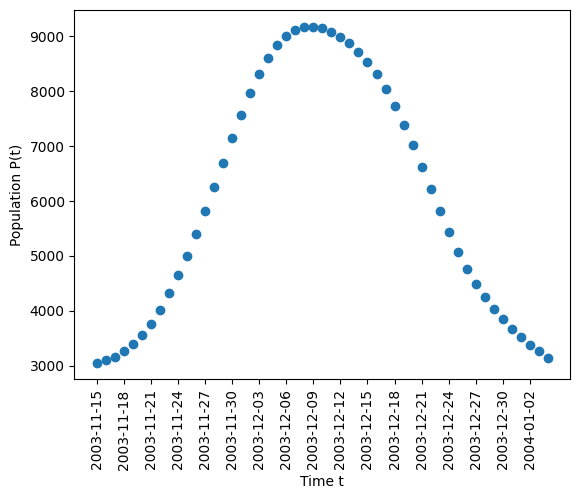

In [7]:
plt.xlabel("Time t")
plt.ylabel("Population P(t)")

plt.plot(pd_datetime_infect['datetime'].tolist(),pd_datetime_infect['infect'].tolist(), 'o')
plt.xticks(pd_datetime_infect['datetime'][::3],  rotation='vertical')
plt.show()

In [8]:
def sir_model(y, t, beta, gamma):
    dS = -beta*y[0]*y[1] /N
    dI =  beta*y[0]*y[1] /N - gamma*y[1]
    dR =  gamma*y[1]
    return [dS, dI, dR]

# Define the parameters
def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))[:,1]

# Initial values 
N = 4681000 # Population of SPB
I0 = pd_datetime_infect['infect'].tolist()[0] 
S0 = N - I0
R0 = 0.0

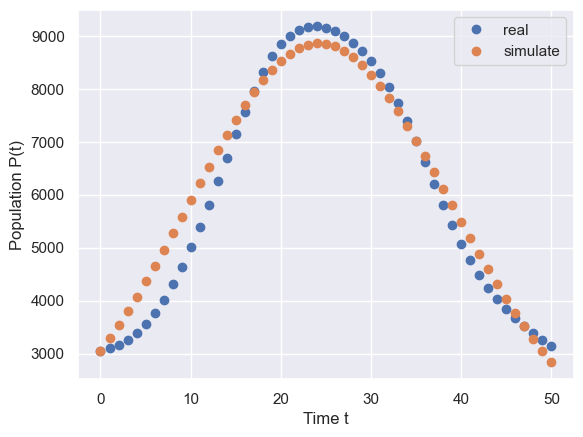

In [9]:
popt, pcov = optimize.curve_fit(fit_odeint, list(range(0,len(pd_datetime_infect['datetime']))),\
                                pd_datetime_infect['infect'])


fitted = fit_odeint(list(range(0,len(pd_datetime_infect['datetime']))), *popt)
sns.set()
plt.xlabel("Time t")
plt.ylabel("Population P(t)")

plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), pd_datetime_infect['infect'], 'o',label ='real')
plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted, 'o',label ='simulate')
plt.legend()

plt.show()

In [10]:
from sklearn.metrics import r2_score
r2_score(pd_datetime_infect['infect'], fitted)

0.9585602169614608

total infected : 317825
total recovered : 458725


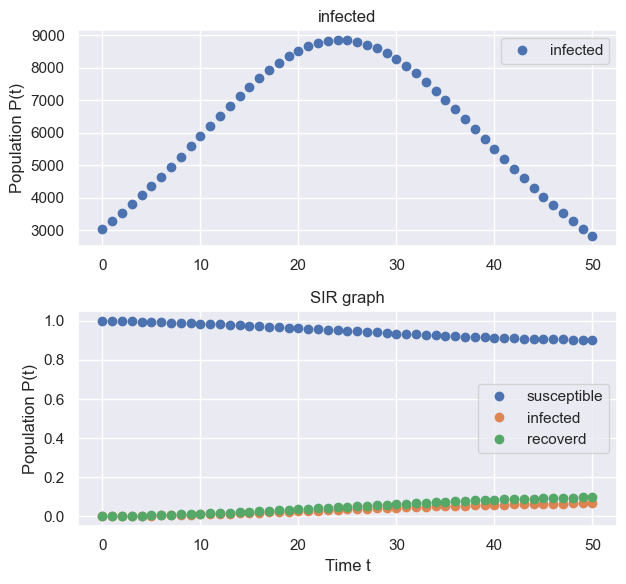

In [11]:

def fit_odeint_for_all(x, beta, gamma):
    return integrate.odeint(sir_model, (S0, I0, R0), x, args=(beta, gamma))
fitted = fit_odeint_for_all(list(range(0,len(pd_datetime_infect['datetime']))), *popt)

fig = plt.figure(figsize=(12,6))
ax = [fig.add_subplot(221, axisbelow=True), 
      fig.add_subplot(223)]


ax[0].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[1], 'o',label='infected')
ax[0].set_ylabel("Population P(t)")
ax[0].set_title('infected')


cum_infected = np.cumsum(fitted.T[1]/N)
ax[1].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[0]/N, 'o',label='susceptible')
ax[1].plot(list(range(0,len(pd_datetime_infect['datetime']))), cum_infected, 'o',label='infected')
ax[1].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[2]/N, 'o',label='recoverd')
ax[1].set_xlabel("Time t")
ax[1].set_ylabel("Population P(t)")
ax[1].set_title('SIR graph')

print(f'total infected : {int(sum(fitted.T[1]))}')
print(f'total recovered : {int(fitted.T[2][-1])}')

for a in ax: 
    a.grid(True)
    a.legend()

plt.tight_layout()

In [12]:
# S : susceptible , E : exposed , I : infected , R : recovered

def seir_model(y, t,beta ,gamma, sigma):
    # susceptible - infected 
    dS = -(beta * y[2]) * y[0] / N 
    # exposed - infected 
    dE = (beta * y[2]) * y[0] / N  - gamma * y[1] 
    # infected - recovered
    dI = gamma * y[1] - sigma * y[2]
    dR = sigma * y[2]
    return [dS, dE, dI, dR]
    
def fit_odeint(x,beta ,gamma, sigma):
    return integrate.odeint(seir_model, (S0, E0, I0, R0), x, args=(beta ,gamma, sigma))[:, 2]

# Initial values 
N = 4681000 # Population of spb
I0 = pd_datetime_infect['infect'].tolist()[0]
E0 = I0 * 1.1
#E0 = 0
R0 = 0.0
S0 = N - I0 - E0 - R0

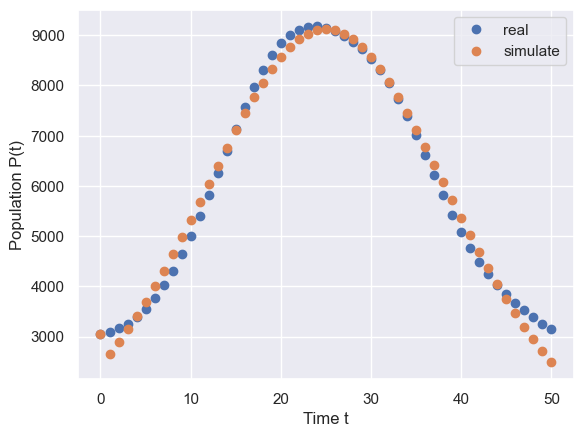

In [13]:
popt, pcov = optimize.curve_fit(fit_odeint, list(range(0,len(pd_datetime_infect['datetime']))),\
                                pd_datetime_infect['infect'])


fitted = fit_odeint(list(range(0,len(pd_datetime_infect['datetime']))), *popt)
sns.set()
plt.xlabel("Time t")
plt.ylabel("Population P(t)")

plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), pd_datetime_infect['infect'], 'o',label ='real')
plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted, 'o',label ='simulate')
plt.legend()

plt.show()

In [14]:
r2_score(pd_datetime_infect['infect'], fitted)


0.9882482084481226

total exposed : 492094
total infected : 309297
total recovered : 770624


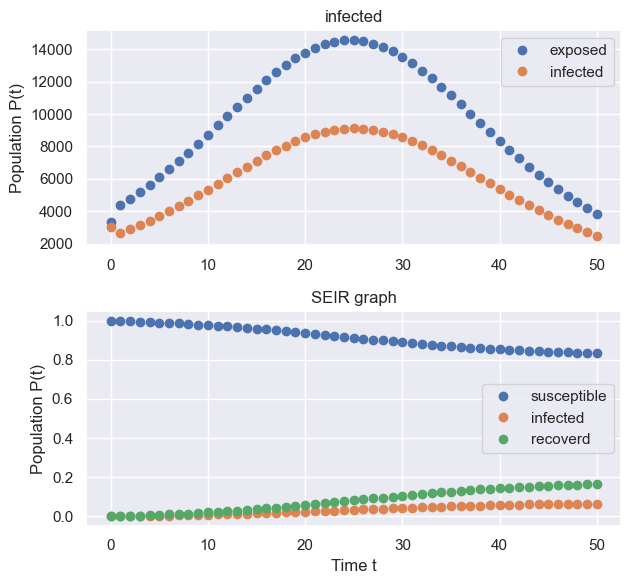

In [15]:
def fit_odeint_for_all(x,beta ,gamma, sigma):
    return integrate.odeint(seir_model, (S0, E0, I0, R0), x, args=(beta ,gamma, sigma))

fitted = fit_odeint_for_all(list(range(0,len(pd_datetime_infect['datetime']))), *popt)

fig = plt.figure(figsize=(12,6))
ax = [fig.add_subplot(221, axisbelow=True), 
      fig.add_subplot(223)]


# plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[0]/N, 'o',label='susceptible')
ax[0].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[1], 'o',label='exposed')
ax[0].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[2], 'o',label='infected')
# plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[3], 'o',label='recoverd')

ax[0].set_ylabel("Population P(t)")
ax[0].set_title('infected')


cum_infected = np.cumsum(fitted.T[2]/N)
ax[1].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[0]/N, 'o',label='susceptible')
ax[1].plot(list(range(0,len(pd_datetime_infect['datetime']))), cum_infected, 'o',label='infected')
ax[1].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[3]/N, 'o',label='recoverd')
ax[1].set_xlabel("Time t")
ax[1].set_ylabel("Population P(t)")
ax[1].set_title('SEIR graph')


print(f'total exposed : {int(sum(fitted.T[1]))}')
print(f'total infected : {int(sum(fitted.T[2]))}')
print(f'total recovered : {int(fitted.T[3][-1])}')
plt.legend()
for a in ax: 
    a.grid(True)
    a.legend()

plt.tight_layout()



In [16]:
# change to minus sign to get most minimizing value
def test(params):
    beta ,gamma, sigma = params
    return -r2_score(pd_datetime_infect['infect'],\
                     integrate.odeint(seir_model, (S0, E0, I0, R0), list(range(0,len(pd_datetime_infect['datetime']))),\
                                      args=(beta ,gamma, sigma))[:, 2])

from scipy.optimize import minimize
#bnds = ((0.095,0.75), (0.2,8), (0.08, 0.33))
res = minimize(test, [1,1,1], method='BFGS', bounds=None, tol=1e-6)
print(res.fun)
res.x

-0.978398051170285


array([3.16604047, 1.42358352, 2.86294065])

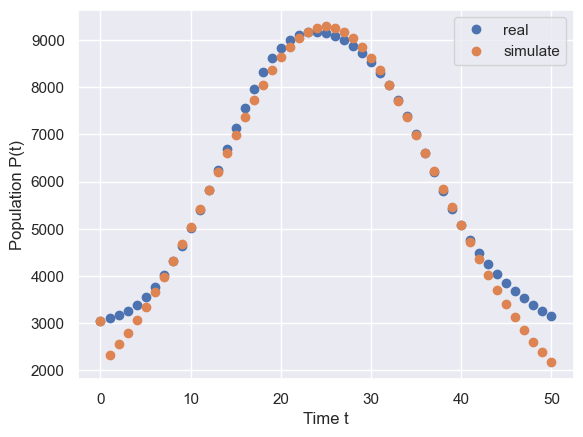

In [17]:

fitted = fit_odeint(list(range(0,len(pd_datetime_infect['datetime']))), *res.x)
sns.set()
plt.xlabel("Time t")
plt.ylabel("Population P(t)")

plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), pd_datetime_infect['infect'], 'o',label ='real')
plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted, 'o',label ='simulate')
plt.legend()

plt.show()

total exposed : 603465
total infected : 301521
total recovered : 855096


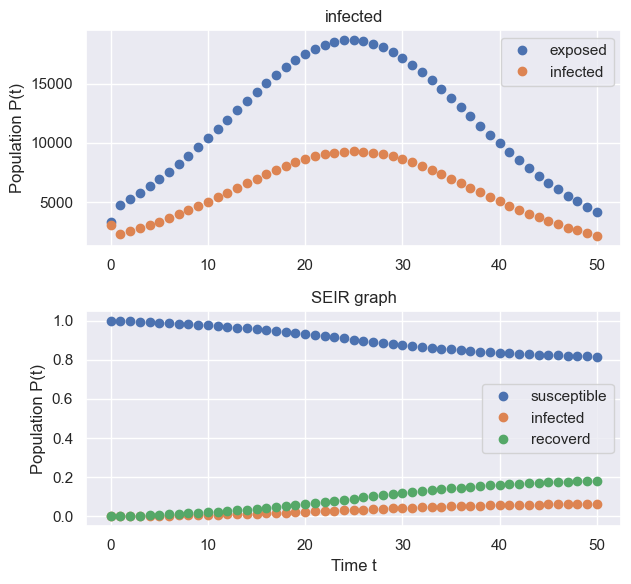

In [18]:
def fit_odeint_for_all(x,beta ,gamma, sigma):
    return integrate.odeint(seir_model, (S0, E0, I0, R0), x, args=(beta ,gamma, sigma))

fitted = fit_odeint_for_all(list(range(0,len(pd_datetime_infect['datetime']))), *res.x)

fig = plt.figure(figsize=(12,6))
ax = [fig.add_subplot(221, axisbelow=True), 
      fig.add_subplot(223)]


# plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[0]/N, 'o',label='susceptible')
ax[0].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[1], 'o',label='exposed')
ax[0].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[2], 'o',label='infected')
# plt.plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[3], 'o',label='recoverd')

ax[0].set_ylabel("Population P(t)")
ax[0].set_title('infected')

cum_infected = np.cumsum(fitted.T[2]/N)
ax[1].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[0]/N, 'o',label='susceptible')
ax[1].plot(list(range(0,len(pd_datetime_infect['datetime']))), cum_infected, 'o',label='infected')
ax[1].plot(list(range(0,len(pd_datetime_infect['datetime']))), fitted.T[3]/N, 'o',label='recoverd')
ax[1].set_xlabel("Time t")
ax[1].set_ylabel("Population P(t)")
ax[1].set_title('SEIR graph')


print(f'total exposed : {int(sum(fitted.T[1]))}')
print(f'total infected : {int(sum(fitted.T[2]))}')
print(f'total recovered : {int(fitted.T[3][-1])}')
for a in ax: 
    a.grid(True)
    a.legend()

plt.tight_layout()
